[View in Colaboratory](https://colab.research.google.com/github/ckbjimmy/2018_mlw/blob/master/sg_ml2.ipynb)

# Deep Learning for Clinical Predictive Analytics

In the previous part, we demonstrated the fundamental steps for MIMIC data preprocessing and analysis. 
We also introduced k-means algorithm for clustering, as well as used logistic regression for classification. 
In the following tutorial, we will introduce more machine learning algorithms, especially deep learning (deep neural network) for the purpose of clinical predictive analytics. 

In this section, we will use a dataset acquired from patients admitted to intensive care units at the Beth Israel Deaconness Medical Center in Boston, MA. 
All patients in the cohort stayed for at least 48 hours, and the goal of the prediction task is to predict in-hospital mortality. 
If you're interested, you can read more about the dataset [here](http://physionet.org/challenge/2012/).

The data is originally provided as hourly observations for a number of variables, and the preprocessing step involved extracting summary statistics across all these observations.
The outcome is the first column `hospitalmortality` (`0` means alive while discharge).
The rest of the data are 182 features you can use to predict this binary outcome.

## More machine learning models

As we see in the previous tutorial, logistic regression is powerful and interpretable. 
However, there are also other useful algorithms that may also yield good performances. 
Python `scikit-learn` provides series of algorithms for you to build the model.

In the following figure (cheat-sheet), though it does not include all algorithms, you can still simply choose the baseline algorithm provided in `scikit-learn` based on the decision nodes:

![sk](http://1.bp.blogspot.com/-ME24ePzpzIM/UQLWTwurfXI/AAAAAAAAANw/W3EETIroA80/s1600/drop_shadows_background.png)

[Source] http://peekaboo-vision.blogspot.com/2013/01/machine-learning-cheat-sheet-for-scikit.html

We quickly show how to use these algorithms through `scikit-learn` implementations.
Here we skip the explanations of all preprocessing details and mathematical details.
For more technical details, please check the [`scikit-learn` documents](http://scikit-learn.org/stable/index.html).



In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

df = pd.read_csv('https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/data/PhysionetChallenge2012_data.csv')
df.head()

,hospitalmortality,ALPMin,ALPMax,ALPFirst,ALPLast,ALPMedian,ALTMin,ALTMax,ALTFirst,ALTLast,...,pHMax,pHFirst,pHLast,pHMedian,MechVentFirst,MechVentLast,MechVentMax,MechVentStartTime,MechVentDuration,TroponinMeasured
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.45,7.45,7.37,7.4,1.0,0.0,1.0,71.0,360.0,0.0
2,0.0,105.0,127.0,127.0,105.0,116.0,75.0,91.0,91.0,75.0,...,7.51,7.51,7.47,7.5,0.0,1.0,1.0,617.0,2160.0,0.0
3,0.0,105.0,105.0,105.0,105.0,105.0,12.0,12.0,12.0,12.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Split features and outcome variable
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# Impute the missing value
X = Imputer(missing_values='NaN', strategy='mean', axis=0).fit(X).transform(X)

# Normalize the data
X = StandardScaler().fit(X).transform(X)

# Encoding Categorical Data
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Put all algorithms in a dictionary, you can add/remove them
clf = {'L1-regularized logistic regression': LogisticRegression(penalty='l1', multi_class='ovr').fit(X_train,y_train),
       'L2-regularized logistic regression': LogisticRegression(penalty='l2', multi_class='ovr').fit(X_train,y_train), 
       'Support vector machine (linear kernel)': LinearSVC(penalty='l2', loss='squared_hinge', C=1.0, multi_class='ovr', random_state=0, max_iter=1000).fit(X_train,y_train), 
       'Support vector machine (RBF kernel)': SVC(kernel='rbf', probability=True, decision_function_shape='ovr').fit(X_train,y_train), 
       'Decision tree': DecisionTreeClassifier(criterion='entropy', splitter='best').fit(X_train,y_train),
       'Random forest': RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train,y_train), 
       'Bagging': BaggingClassifier(n_estimators=10).fit(X_train, y_train),
       'Adaptive boosting': AdaBoostClassifier(n_estimators=100).fit(X_train,y_train), 
       'Gradieng boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train,y_train)
       }

# Use 5-fold cross-validation to estimate the performance of each model
print('Acc\tAUROC\tModel')
for curr_mdl in clf:
    scores = cross_val_score(clf[curr_mdl], X_test, y_test, cv=5, scoring='accuracy')
    auc = cross_val_score(clf[curr_mdl], X_test, y_test, cv=5, scoring='roc_auc')
    print('{:0.3f}\t{:0.3f}\t{}'.format(scores.mean(), auc.mean(), curr_mdl))

Acc	AUROC	Model
0.823	0.753	L1-regularized logistic regression
0.820	0.758	L2-regularized logistic regression
0.800	0.737	Support vector machine (linear kernel)
0.850	0.765	Support vector machine (RBF kernel)
0.774	0.554	Decision tree
0.866	0.807	Random forest
0.864	0.767	Bagging
0.835	0.692	Adaptive boosting
0.824	0.721	Gradieng boosting


From this simple experiment, we can see the performance of different machine learning approaches.


## Deep learning / Deep neural network

Deep learning is a group of machine learning algorithms that specifically focuses on utilizing neural network architecture.
The neural network approach attempt to mimic the function of biological neurons by stacking layers of neuron units that can pass information.
The network will pass the inforamtion back and forth to adjust the weights of neuron units using backpropagation algorithm based on the objective function (loss function, criterion) that we provide.

The advantages of using deep learning approach includes:
- Modularization
- Universality theorem (one hidden layer is enough, but much effective while deeper)
- End-to-end learning (less feature engineering---if you don't know what features are important at all)

![adv](https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/img/adv.png)
[Source] Courtesy by Prof. HY Lee (NTU)

However, there are still some cons of using deep neural networks such as interpretability and heavy computation.

As a promising algorithmic approach for predictive analytics (and also the hype of deep learning), we would like to introduce you how to use deep neural networks for clinical machine learning problems.

The mathematical details of neural network approach will not be emphasized in the tutorial.
The foundation of deep neural network is using **gradient descent** to update parameters, and all gradients are computed by **backpropagation algorithm**.
Please refer to [Deep Learning book by Goodfellow et al.](http:/www.deeplearningbook.org/) for detailed information.  

To build the neural network without too much efforts in python, we adopt the high-level python deep learning API, **Keras**, to train neural networks.

After going through this tutorial, we hope that you will understand how to use keras to design and build simple neural network for classification problems, and how to evaluate the keras neural network models.

In this tutorial, we use the PhysioNet dataset, as an example to demonstrate the performance of deep learning models.

Before training neural network, we need to do some transformations for our data as we did before.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/data/PhysionetChallenge2012_data.csv')
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X = Imputer(missing_values='NaN', strategy='mean', axis=0).fit(X).transform(X)
X = StandardScaler().fit(X).transform(X)

labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Next, we import keras modules and construct a very simple three-layer neural network architecture with input, hidden and output layers.

In [4]:
!pip install keras --upgrade
import keras
from keras.models import Sequential
from keras.layers import Dense

try:
    import pydot
except:
    !pip install pydot
    
try:
    import graphviz
except:
    !apt-get install graphviz -y
    
from keras.utils.vis_utils import plot_model
from IPython.display import Image

keras.__version__

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.2.0)
Requirement not upgraded as not directly required: numpy>=1.9.1 in /usr/local/lib/python3.6/dist-packages (from keras) (1.14.5)
Requirement not upgraded as not directly required: h5py in /usr/local/lib/python3.6/dist-packages (from keras) (2.8.0)
Requirement not upgraded as not directly required: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from keras) (1.11.0)
Requirement not upgraded as not directly required: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from keras) (0.19.1)
Requirement not upgraded as not directly required: keras-applications==1.0.2 in /usr/local/lib/python3.6/dist-packages (from keras) (1.0.2)
Requirement not upgraded as not directly required: keras-preprocessing==1.0.1 in /usr/local/lib/python3.6/dist-packages (from keras) (1.0.1)
Requirement not upgraded as not directly required: pyyaml in /usr/local/lib/python3.6/dist-packages (from keras) (3.12)
art 1.5 has

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


'2.2.0'

There are many variants of deep neural networks.

![nn](https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/img/nn.png)
[Source] Deep Learning, Chapter 1 (Goodfellow, 2016)

We will start from the simplest one, feedforward neural network, which is similar to the neural network architecture shown in the following figure.

![nn](https://cdn-images-1.medium.com/max/1600/1*QVIyc5HnGDWTNX3m-nIm9w.png)

[Source] https://medium.com/@curiousily/tensorflow-for-hackers-part-iv-neural-network-from-scratch-1a4f504dfa8

In our first neural network model, we will construct the one that

- take the input and pass them into the 64-dimension first hidden layer, 
- take the output of the first layer and pass them into the  8-dimension second layer,
- take the output of the second layer and pass them into the last layer for prediction,
- the output of the last layer is the prediction.

One more hidden layer than the above figure.

In keras, we use `Sequential()` as the skeleton of the neural network model, and sequentially add the layer on it.
After building the layers, we need to compile the model and defined the optimizer, loss function and evaluation metrics to optimize our model.
In this example, we use the optimizer called `adam`, to minimize the value of loss function `binary_crossentropy` (if you work on the regression problem, remember to change to `mse`), and judge by accuracy.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                11712     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 12,241
Trainable params: 12,241
Non-trainable params: 0
_________________________________________________________________
None


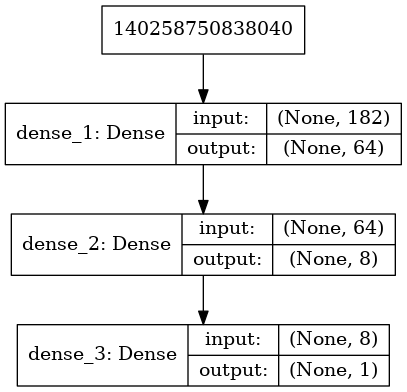

In [5]:
# initialize neural network
clf = Sequential()

# first hidden layer for input data
clf.add(Dense(units=64, 
              kernel_initializer='uniform',
              activation='relu', 
              input_dim=X.shape[1]))

# second hidden layer
clf.add(Dense(units=8, 
              kernel_initializer='uniform', 
              activation='relu'))

# the last hidden layer for output
clf.add(Dense(units=1, 
              kernel_initializer='uniform', 
              activation='sigmoid'))

# compile the network
clf.compile(optimizer='adam', 
            loss='binary_crossentropy', 
            metrics=['accuracy'])


print(clf.summary())

plot_model(clf, to_file='clf.png', show_shapes=True, show_layer_names=True)
Image('clf.png')

Then, it's time to train the model!
Smaller batch size usually yields better performance, yet with slow speed.
The epoch size of $n$ means that the algorithm will go through whole dataset $n$ times.

After training, we visualize the training history and see how the accuracy and loss went during the process.
We also use confusion matrix and **pycm** for computing the performance.


In [6]:
# fit model
history = clf.fit(x=X_train, y=y_train,
                    validation_split=0.2,  
                    batch_size=100,
                    epochs=20, 
                    verbose=1)

Train on 2560 samples, validate on 640 samples
Epoch 1/20
2560/2560 [==============================] - 0s 92us/step - loss: 0.6706 - acc: 0.8605 - val_loss: 0.6213 - val_acc: 0.8734
Epoch 2/20
2560/2560 [==============================] - 0s 19us/step - loss: 0.5233 - acc: 0.8625 - val_loss: 0.3914 - val_acc: 0.8734
Epoch 3/20
2560/2560 [==============================] - 0s 17us/step - loss: 0.3536 - acc: 0.8625 - val_loss: 0.3157 - val_acc: 0.8734
Epoch 4/20
2560/2560 [==============================] - 0s 17us/step - loss: 0.3210 - acc: 0.8625 - val_loss: 0.3012 - val_acc: 0.8734
Epoch 5/20
2560/2560 [==============================] - 0s 17us/step - loss: 0.3048 - acc: 0.8625 - val_loss: 0.2960 - val_acc: 0.8734
Epoch 6/20
2560/2560 [==============================] - 0s 19us/step - loss: 0.2943 - acc: 0.8625 - val_loss: 0.2909 - val_acc: 0.8734
Epoch 7/20
2560/2560 [==============================] - 0s 18us/step - loss: 0.2838 - acc: 0.8625 - val_loss: 0.2868 - val_acc: 0.8734
Epoch 8/

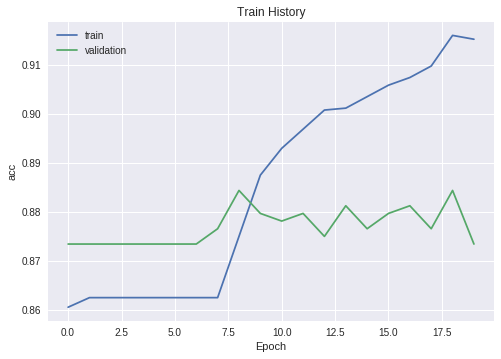

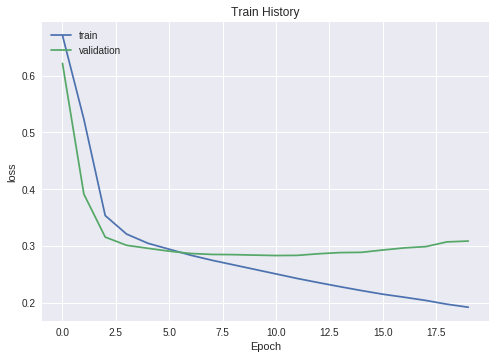

In [7]:
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])   
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show() 
    
show_train_history(history, 'acc', 'val_acc')
show_train_history(history, 'loss', 'val_loss')

In [8]:
# we use the trained model to predict the label of test set
y_pred = clf.predict(X_test)
y_pred = [1 if i[0] > 0.5 else 0 for i in y_pred]

# show the performance using confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred) 
print(cm)

[[653  26]
 [ 81  40]]


In [9]:
# we use pycm to show the performance
!pip install pycm
from pycm import *

cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)
print(cm)

    100% |████████████████████████████████| 573kB 5.4MB/s 
tensorflow 1.9.0rc2 has requirement setuptools<=39.1.0, but you'll have setuptools 39.2.0 which is incompatible.
  Found existing installation: setuptools 39.1.0
    Uninstalling setuptools-39.1.0:
      Successfully uninstalled setuptools-39.1.0
Predict          0        1        
Actual
0                653      26       
1                81       40       




Overall Statistics : 

95% CI                                                           (0.84266,0.88984)
Bennett_S                                                        0.7325
Chi-Squared                                                      None
Chi-Squared DF                                                   1
Conditional Entropy                                              None
Cramer_V                                                         None
Cross Entropy                                                    0.64985
Gwet_AC1                                       

After seeing a simple example, we discuss more about the network.
Normally, when building a neural network, we will do the following steps:

### Define a set of function (Network architecture)
We can see that the neuron unit can be regarded as a logistic regression-like operation.
In general, the unit will do `activation_function(weight * input + bias)` computation.

![ff](https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/img/ff.png)

[Source] Courtesy by Prof. HY Lee (NTU)

In the feedforward model, the layer function we used is `Dense` (fully-connected layer).
For the `Dense` layer, you need to assign the input size, output size (`units`), and the activation function.
For activation function, you can try the following options: `softplus`, `softsign`, `relu`, `tanh`, `sigmoid`, `hard_sigmoid`, `linear`, depends on your needs.
However, `relu` are the most commonly used functions for intermediate layers, and `sigmoid`/`softmax` for the last layer (binary/multiclass).

Multiple hidden layers are good, but there is no theorerical consensus how many layers / how many neurons / what hyperparameters you need to use to get the best performance. (That's why some people think that deep learning approach has become [alchemy](https://www.reddit.com/r/compsci/comments/7jiipp/lecun_vs_rahimi_has_machine_learning_become/))

![stack](https://1.bp.blogspot.com/-gZ7UBZ-wiBE/WZU12kj6wDI/AAAAAAAAKNQ/U8998PG8U30fgzZUWVtQhzl5fpVlCxnSwCLcBGAs/s1600/layers.jpg))

[Source] http://www.cl.cam.ac.uk/~pv273/slides/LOSSlides.pdf

### Goodness of function (Define loss)
The goal of prediction is to minimize the difference between the predicted value and the ground truth label. 
We need to decide how to compute the difference between them, we call this "objective" in deep learning.

![loss](https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/img/loss.png)

[Source] Courtesy by Prof. HY Lee (NTU)

In the first case, we will use `binary_crossentropy` for the binary classification task. 
For more objectives, please refer to the [keras document](https://keras.io/objectives/).

### Choose the best function (Optimization and parameter setting)
We also need to decide which optimizer will be used in the network. 
The commonly used optimizers include: `SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam`.
The backpropagation algorithm will use the selected optimizer to minimize the objective (loss) function we defined previously.
Finally, we need to decide the parameters `batch_size` and `epochs` for training. 
Batch size influences the speed and performance so you have to tune it and do some experiments.
If you have $1000$ training samples and set `batch_size=50`, then in one epoch (going through all training samples once) you need to update parameters for $\frac{1000}{50}=20$ times, until all "mini-batches" are picked.

For prediction, you can simply use `model.evaluate()` to get the performance metrics, and use `model.predict()` to obtain the predicted results.

### (optional) Exercise of regularization
Regularization is a pratical way to prevent from overfitting problem. 
You may try to add `BatchNormalization` (batch normalization) or `Dropout` (dropout) layers and see whether they will be helpful for modeling.




## Exercise

Now try to play with the breast cancer dataset and see whether deep neural network works well on the smaller dataset.

The [breast cancer dataset in UCI data repository](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names) help us build models with well-structured data (without missing data and other data cleaning problems). 
The python machine learning package `scikit-learn` has already helped us preprocess the data. 
We load the breast cancer dataset from `sklearn.datasets`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________
None
Train on 364 samples, validate on 91 samples
Epoch 1/50
364/364 [==============================] - 0s 616us/step - loss: 0.6783 - acc: 0.3736 - val_loss: 0.6698 - val_acc: 0.3626
Epoch 2/50
364/364 [==============================] - 0s 38us/step - loss: 0.6579 - acc: 0.3736 - val_loss: 0.6538 - val_acc: 0.3626
Epoch 3/50
364/364 [==============================] - 0s 30us/step - loss: 0.6415 - acc: 0.

364/364 [==============================] - 0s 22us/step - loss: 0.2529 - acc: 0.9148 - val_loss: 0.2944 - val_acc: 0.9011
Epoch 22/50
364/364 [==============================] - 0s 33us/step - loss: 0.2408 - acc: 0.9093 - val_loss: 0.3338 - val_acc: 0.8681
Epoch 23/50
364/364 [==============================] - 0s 33us/step - loss: 0.2437 - acc: 0.9038 - val_loss: 0.2917 - val_acc: 0.9011
Epoch 24/50
364/364 [==============================] - 0s 28us/step - loss: 0.2362 - acc: 0.9148 - val_loss: 0.2856 - val_acc: 0.9011
Epoch 25/50
364/364 [==============================] - 0s 25us/step - loss: 0.2298 - acc: 0.9121 - val_loss: 0.3234 - val_acc: 0.8681
Epoch 26/50
364/364 [==============================] - 0s 32us/step - loss: 0.2489 - acc: 0.9038 - val_loss: 0.2825 - val_acc: 0.9011
Epoch 27/50
364/364 [==============================] - 0s 26us/step - loss: 0.2853 - acc: 0.8874 - val_loss: 0.2810 - val_acc: 0.9011
Epoch 28/50
364/364 [==============================] - 0s 25us/step - loss

Epoch 46/50
364/364 [==============================] - 0s 23us/step - loss: 0.2183 - acc: 0.9148 - val_loss: 0.2741 - val_acc: 0.9011
Epoch 47/50
364/364 [==============================] - 0s 27us/step - loss: 0.2149 - acc: 0.9176 - val_loss: 0.2860 - val_acc: 0.9011
Epoch 48/50
364/364 [==============================] - 0s 35us/step - loss: 0.2175 - acc: 0.9148 - val_loss: 0.2738 - val_acc: 0.9011
Epoch 49/50
364/364 [==============================] - 0s 27us/step - loss: 0.2227 - acc: 0.9203 - val_loss: 0.2648 - val_acc: 0.9011
Epoch 50/50
364/364 [==============================] - 0s 27us/step - loss: 0.2121 - acc: 0.9231 - val_loss: 0.2958 - val_acc: 0.8791


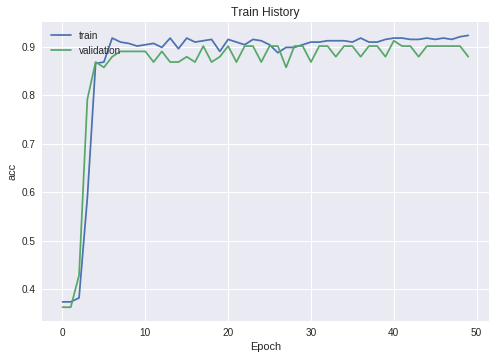

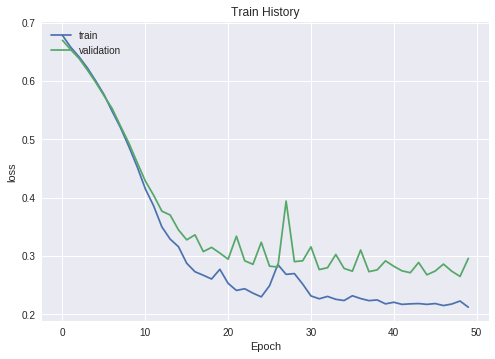

Predict          0        1        
Actual
0                36       7        
1                0        71       




Overall Statistics : 

95% CI                                                           (0.89453,0.98267)
Bennett_S                                                        0.87719
Chi-Squared                                                      None
Chi-Squared DF                                                   1
Conditional Entropy                                              None
Cramer_V                                                         None
Cross Entropy                                                    0.96824
Gwet_AC1                                                         0.88777
Joint Entropy                                                    None
KL Divergence                                                    0.0122
Kappa                                                            0.86497
Kappa 95% CI                                                    

In [10]:
from sklearn import datasets

df_bc = datasets.load_breast_cancer()
X = df_bc['data']
y = df_bc['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

clf = Sequential()
clf.add(Dense(units=16, 
              kernel_initializer='uniform',
              activation='relu', 
              input_dim=X.shape[1]))
clf.add(Dense(units=16, 
              kernel_initializer='uniform', 
              activation='relu'))
clf.add(Dense(units=1, 
              kernel_initializer='uniform', 
              activation='sigmoid'))
clf.compile(optimizer='adam', 
            loss='binary_crossentropy', 
            metrics=['accuracy'])
print(clf.summary())

history = clf.fit(x=X_train, y=y_train,
                    validation_split=0.2,  
                    batch_size=100,
                    epochs=50, 
                    verbose=1)

show_train_history(history, 'acc', 'val_acc')
show_train_history(history, 'loss', 'val_loss')

y_pred = clf.predict(X_test)
y_pred = [1 if i[0] > 0.5 else 0 for i in y_pred]

cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)
print(cm)

## Convolutional neural network (CNN) for image data

Sometimes we will use image instead of structured tabular data for clinical data predictive analytics.
Here we show a very simple image classification workflow using [MNIST handwriting database](https://en.wikipedia.org/wiki/MNIST_database) since there is no small but suitable medical image dataset for simple demonstration with deep neural network.

For more medical image data, you may check the public repository such as [The Cancer Imaging Archive (TCIA)](http://www.cancerimagingarchive.net/) by NIH.
However, all data from repository are raw DICOM images and you need to preprocess them before training a model.

Although not biomedical/clinical, MNIST is already included in the `keras` and we can simply load it through the `keras` provided functions.
But we still need to do reshape the data to the proper format, and normalize them before feed into the model.

First, we will just simply use the feedforward neural network for image classification (10 classes).

In [11]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
from keras.datasets import mnist

# load MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape the data
X_train = X_train.reshape(60000, 28*28).astype('float32')
X_test = X_test.reshape(10000, 28*28).astype('float32')
  
# normalize the data
X_train = X_train/255
X_test = X_test/255

# for keras classification, we need to use `to_categorical` to transform the label to appropriate format
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
None


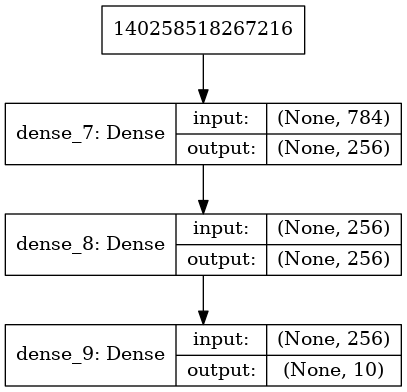

In [12]:
clf = Sequential()
clf.add(Dense(units=256, 
                input_dim=784, 
                kernel_initializer='normal', 
                activation='relu'))
clf.add(Dense(units=256, 
                input_dim=64, 
                kernel_initializer='normal', 
                activation='relu'))
clf.add(Dense(units=10, 
                kernel_initializer='normal', 
                activation='softmax'))
print(clf.summary())

plot_model(clf, to_file='clf.png', show_shapes=True, show_layer_names=True)
Image('clf.png')

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 3s - loss: 0.3853 - acc: 0.8924 - val_loss: 0.1788 - val_acc: 0.9480
Epoch 2/10
 - 2s - loss: 0.1424 - acc: 0.9580 - val_loss: 0.1284 - val_acc: 0.9616
Epoch 3/10
 - 2s - loss: 0.0922 - acc: 0.9728 - val_loss: 0.0969 - val_acc: 0.9724
Epoch 4/10
 - 2s - loss: 0.0669 - acc: 0.9800 - val_loss: 0.0893 - val_acc: 0.9726
Epoch 5/10
 - 2s - loss: 0.0480 - acc: 0.9857 - val_loss: 0.0813 - val_acc: 0.9758
Epoch 6/10
 - 2s - loss: 0.0362 - acc: 0.9893 - val_loss: 0.0840 - val_acc: 0.9746
Epoch 7/10
 - 2s - loss: 0.0264 - acc: 0.9924 - val_loss: 0.0826 - val_acc: 0.9766
Epoch 8/10
 - 2s - loss: 0.0236 - acc: 0.9928 - val_loss: 0.0862 - val_acc: 0.9770
Epoch 9/10
 - 2s - loss: 0.0201 - acc: 0.9933 - val_loss: 0.0832 - val_acc: 0.9780
Epoch 10/10
 - 2s - loss: 0.0111 - acc: 0.9970 - val_loss: 0.0938 - val_acc: 0.9756


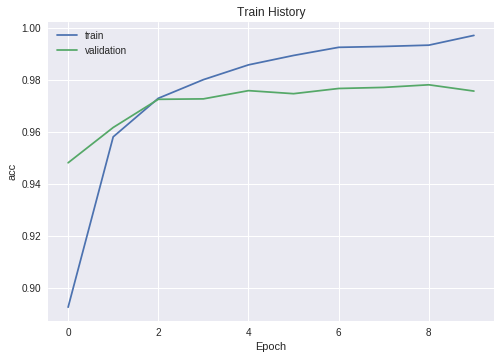

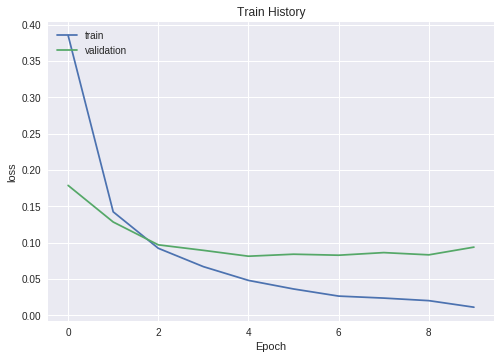

10000/10000 [==============================] - 0s 34us/step
Accuracy of testing data = 97.7%


In [13]:
clf.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = clf.fit(x=X_train, y=y_train, 
                    validation_split=0.2,  
                    batch_size=200, 
                    epochs=10,
                    verbose=2)

show_train_history(history, 'acc', 'val_acc')
show_train_history(history, 'loss', 'val_loss')

scores = clf.evaluate(X_test, y_test)  
print("Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

We can see that feedforward neural network can do a very good job on image classification. 
However, we may also use **convolutional neural network** (CNN), to do classification considering spatial information.

The key steps in CNN are:

- Convolution
- Pooling

The idea of convolution is to have **sparse connectivity** (each neuron only connects to parts of the previous layer) and **parameter sharing** (neurons can use the same set of parameters). 

![conv](https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/img/conv.png)

[Source] Deep Learning, Chapter 9 (Goodfellow, 2016)

The pooling strategy also group the neurons corresponding to the same filter with nearby receptive fields.

![pool](https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/img/pool.png)

[Source] Deep Learning, Chapter 9 (Goodfellow, 2016)

These characteristics preserve the spatial information, as well as reduce the model size significantly.

The following figure demonstrates the process of CNN on MNIST data.

![cnn](https://codetolight.files.wordpress.com/2017/11/network.png)

[Source] https://codetolight.files.wordpress.com/2017/11/network.png

In the following codes, we will use `keras` to build the same model and see how the performance goes using CNN on MNIST.
You may compare the value of the figure and those in the sequential model below.

We can see that the performance significantly increase using CNN approach for image data.

You can also play with changing the value of parameters such as `filters`,  `activation`,  `pool_size`,  `drop_out`, `Dense` and see how the performance will change.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        260       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 20)        5020      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 20)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 980)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               98100     
__________

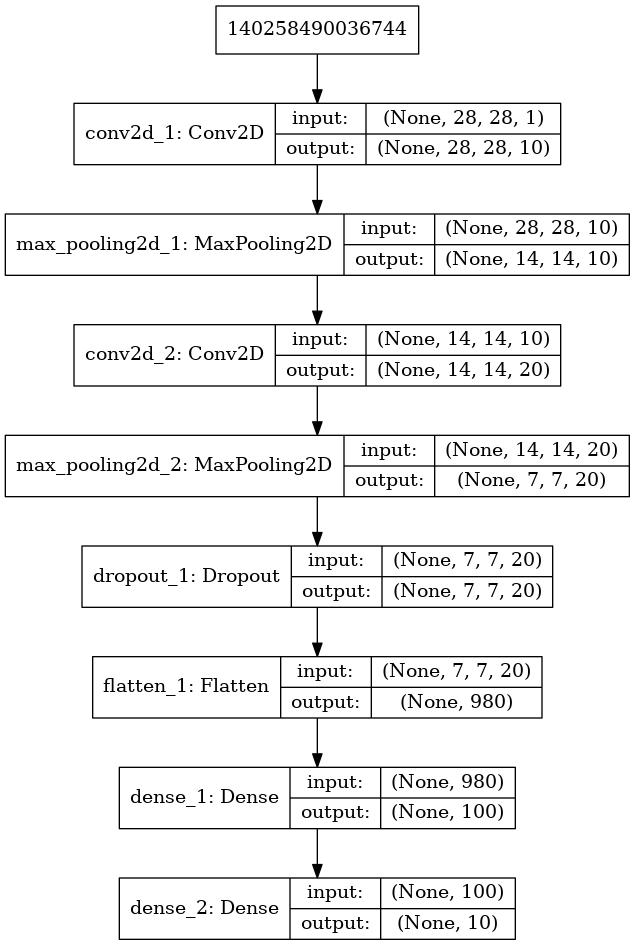

In [14]:
from keras.layers import Dropout, Flatten, Conv2D, MaxPool2D 

(X_train, y_train), (X_test, y_test) = mnist.load_data()  
  
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')  
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

X_train = X_train / 255  
X_test = X_test /255  
  
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

clf = Sequential()  
clf.add(Conv2D(filters=10,  
                 kernel_size=(5, 5),  
                 padding='same',  
                 input_shape=(28, 28, 1),  
                 activation='relu',
                 name='conv2d_1')) 
clf.add(MaxPool2D(pool_size=(2,2), 
                    name='max_pooling2d_1'))  
clf.add(Conv2D(filters=20,  
                 kernel_size=(5, 5),  
                 padding='same',  
                 input_shape=(28, 28, 1),  
                 activation='relu',
                 name='conv2d_2'))  
clf.add(MaxPool2D(pool_size=(2,2), 
                    name='max_pooling2d_2'))  
clf.add(Dropout(0.25, name='dropout_1'))
clf.add(Flatten(name='flatten_1'))
clf.add(Dense(100, activation='relu', name='dense_1'))  
#clf.add(Dropout(0.5, name='dropout_2'))
clf.add(Dense(10, activation='softmax', name='dense_2'))
print(clf.summary())

plot_model(clf, to_file='clf.png', show_shapes=True, show_layer_names=True)
Image('clf.png')

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 58s 1ms/step - loss: 0.4250 - acc: 0.8741 - val_loss: 0.1083 - val_acc: 0.9678
Epoch 2/10
46000/48000 [===========================>..] - ETA: 2s - loss: 0.1093 - acc: 0.9666

48000/48000 [==============================] - 58s 1ms/step - loss: 0.1084 - acc: 0.9670 - val_loss: 0.0716 - val_acc: 0.9782
Epoch 3/10
48000/48000 [==============================] - 58s 1ms/step - loss: 0.0784 - acc: 0.9759 - val_loss: 0.0555 - val_acc: 0.9833
Epoch 4/10
25400/48000 [==============>...............] - ETA: 24s - loss: 0.0655 - acc: 0.9799

48000/48000 [==============================] - 58s 1ms/step - loss: 0.0629 - acc: 0.9809 - val_loss: 0.0462 - val_acc: 0.9858
Epoch 5/10
48000/48000 [==============================] - 58s 1ms/step - loss: 0.0513 - acc: 0.9843 - val_loss: 0.0440 - val_acc: 0.9854
Epoch 6/10
20600/48000 [===========>..................] - ETA: 29s - loss: 0.0442 - acc: 0.9863

48000/48000 [==============================] - 57s 1ms/step - loss: 0.0437 - acc: 0.9864 - val_loss: 0.0374 - val_acc: 0.9885
Epoch 7/10
48000/48000 [==============================] - 57s 1ms/step - loss: 0.0387 - acc: 0.9883 - val_loss: 0.0363 - val_acc: 0.9892
Epoch 8/10
19400/48000 [===========>..................] - ETA: 30s - loss: 0.0363 - acc: 0.9882

48000/48000 [==============================] - 58s 1ms/step - loss: 0.0357 - acc: 0.9885 - val_loss: 0.0345 - val_acc: 0.9885
Epoch 9/10
48000/48000 [==============================] - 58s 1ms/step - loss: 0.0297 - acc: 0.9898 - val_loss: 0.0399 - val_acc: 0.9888
Epoch 10/10
19000/48000 [==========>...................] - ETA: 31s - loss: 0.0266 - acc: 0.9922

48000/48000 [==============================] - 58s 1ms/step - loss: 0.0286 - acc: 0.9910 - val_loss: 0.0345 - val_acc: 0.9899


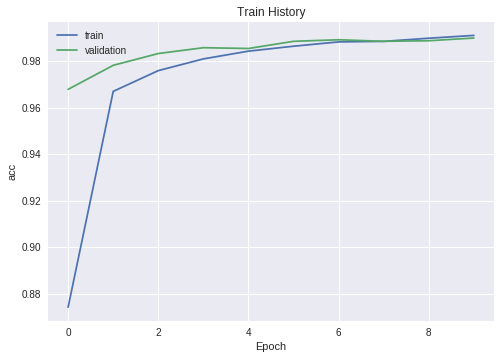

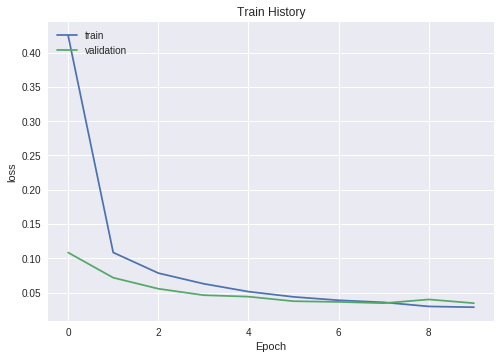

10000/10000 [==============================] - 6s 619us/step
Accuracy of testing data = 99.1%


In [15]:
clf.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])  
  
history = clf.fit(x=X_train, y=y_train,
                    validation_split=0.2,  
                    batch_size=200,
                    epochs=10, 
                    verbose=1)

show_train_history(history, 'acc', 'val_acc')
show_train_history(history, 'loss', 'val_loss')

scores = clf.evaluate(X_test, y_test)  
print("Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

## Recurrent neural network (RNN) for sequential data / text

Text data are even much important for clinical data predictive analytics since they usually include a lot of information that are not saved in the tabular data.
However, preprocessing text data is quite messy and time-consuming (but extremely important).
We won't cover this part in the tutorial but only quickly go through the modeling.

We again show a simple text sentiment classification workflow using [IMDB Movie reviews sentiment classification database](https://keras.io/datasets/), which is already preprocessed and labeled.

For your own text data, please make sure that they are in the same format as the IMDB dataset in `keras`.

For text data, you will use a type of neural network, **recurrent neural network** (RNN) for the sequential information. 
RNN and its variants can be used for different kinds of sequential data such as text, speech, audio or time-series data.

RNN has the feature of memorizing the previous input while training through passing the hidden state to the neural network again and again---which is suitable for sequential modeling.

![rnn](https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/img/rnn.png)

[Source] Deep Learning, Chapter 10 (Goodfellow, 2016)

Here we just demonstrate two approaches of modeling the IMDB data:

- using a RNN variant, long short term memory neural network (LSTM) for modeling,
- combining CNN and LSTM for modeling (CNN for compressing the sequence information).

For the detailed differences of neural network architecture, please check the figure of neural networks below.

To make the modeling process simpler, we make all sequences (texts) the same length using zero padding.

17465344/17464789 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           96000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 149,301
Trainable params: 149,301
Non-trainable params: 0
_________________________________________________________________
None


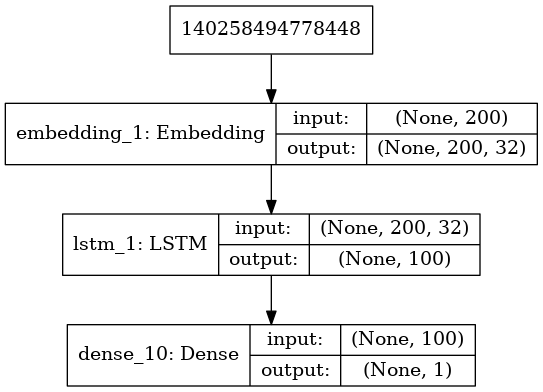

In [16]:
from keras.datasets import imdb
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

top_words = 3000
max_review_length = 200
embedding_vecor_length = 32

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

# LSTM
clf = Sequential()
clf.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
clf.add(LSTM(100))
clf.add(Dense(1, activation='sigmoid'))
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(clf.summary())

plot_model(clf, to_file='clf.png', show_shapes=True, show_layer_names=True)
Image('clf.png')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.6079 - acc: 0.6839 - val_loss: 0.4370 - val_acc: 0.8262
Epoch 2/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.3350 - acc: 0.8601 - val_loss: 0.3202 - val_acc: 0.8638
Epoch 3/10
20000/20000 [==============================] - 76s 4ms/step - loss: 0.2731 - acc: 0.8920 - val_loss: 0.3073 - val_acc: 0.8740
Epoch 4/10
 5200/20000 [======>.......................] - ETA: 52s - loss: 0.2369 - acc: 0.9071

20000/20000 [==============================] - 75s 4ms/step - loss: 0.2476 - acc: 0.9042 - val_loss: 0.3145 - val_acc: 0.8696
Epoch 5/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.2322 - acc: 0.9104 - val_loss: 0.3283 - val_acc: 0.8680
Epoch 6/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.2235 - acc: 0.9126 - val_loss: 0.3534 - val_acc: 0.8484
Epoch 7/10
14000/20000 [====================>.........] - ETA: 21s - loss: 0.2158 - acc: 0.9186

20000/20000 [==============================] - 75s 4ms/step - loss: 0.2208 - acc: 0.9150 - val_loss: 0.3402 - val_acc: 0.8668
Epoch 8/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.2051 - acc: 0.9223 - val_loss: 0.3417 - val_acc: 0.8526
Epoch 9/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.1958 - acc: 0.9253 - val_loss: 0.3535 - val_acc: 0.8636
Epoch 10/10
15400/20000 [======================>.......] - ETA: 16s - loss: 0.1833 - acc: 0.9300

20000/20000 [==============================] - 75s 4ms/step - loss: 0.1885 - acc: 0.9291 - val_loss: 0.3756 - val_acc: 0.8590


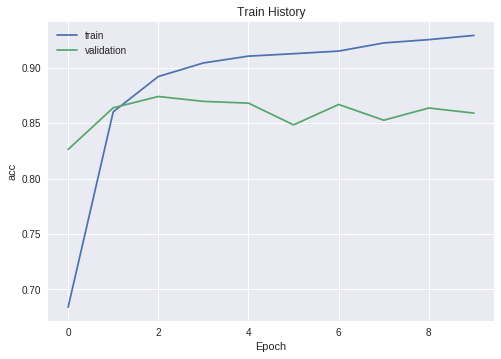

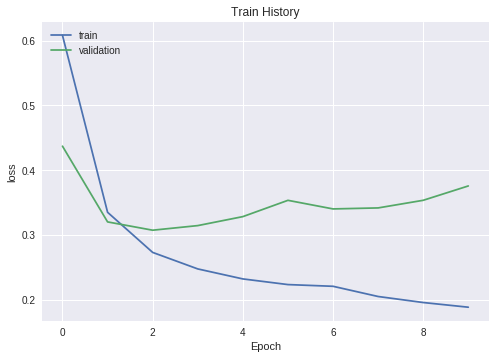

25000/25000 [==============================] - 30s 1ms/step
Accuracy of testing data = 85.9%


In [17]:
history = clf.fit(x=X_train, y=y_train,
                    validation_split=0.2,  
                    batch_size=200,
                    epochs=10, 
                    verbose=1)

show_train_history(history, 'acc', 'val_acc')
show_train_history(history, 'loss', 'val_loss')

scores = clf.evaluate(X_test, y_test)  
print("Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

Finally, we would like to combine CNN and RNN for sequential modeling.
We utilize CNN to reduce the length of sequence and the number of parameters, in order to make the RNN training much efficient and robust (less issue of long-term dependency).

The basic idea is shown in the following figure.

![1dcnn](https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/img/1dcnn.png)

[Source] Kim, 2014


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           96000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total para

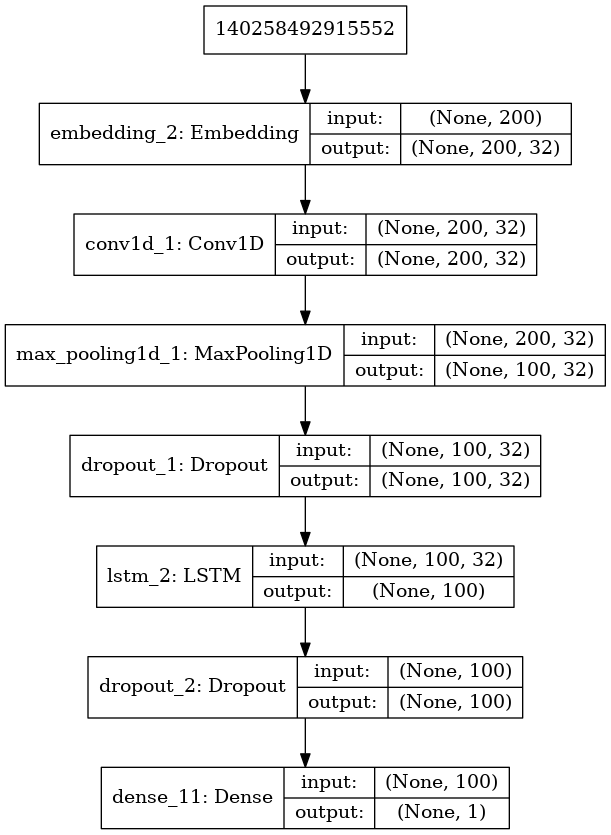

In [18]:
from keras.layers.convolutional import Conv1D, MaxPooling1D

# CNN + LSTM
clf = Sequential()
clf.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
clf.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
clf.add(MaxPooling1D(pool_size=2))
clf.add(Dropout(0.2))
clf.add(LSTM(100))
clf.add(Dropout(0.2))
clf.add(Dense(1, activation='sigmoid'))
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(clf.summary())
plot_model(clf, to_file='clf.png', show_shapes=True, show_layer_names=True)
Image('clf.png')

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 45s 2ms/step - loss: 0.5777 - acc: 0.6822 - val_loss: 0.3380 - val_acc: 0.8624
Epoch 2/10
20000/20000 [==============================] - 43s 2ms/step - loss: 0.3006 - acc: 0.8760 - val_loss: 0.3008 - val_acc: 0.8732
Epoch 3/10
20000/20000 [==============================] - 43s 2ms/step - loss: 0.2529 - acc: 0.8995 - val_loss: 0.3017 - val_acc: 0.8722
Epoch 4/10
 5200/20000 [======>.......................] - ETA: 29s - loss: 0.2041 - acc: 0.9231

20000/20000 [==============================] - 59s 3ms/step - loss: 0.2244 - acc: 0.9120 - val_loss: 0.3210 - val_acc: 0.8706
Epoch 5/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.2060 - acc: 0.9215 - val_loss: 0.3582 - val_acc: 0.8644
Epoch 6/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.1945 - acc: 0.9257 - val_loss: 0.3249 - val_acc: 0.8712
Epoch 7/10
14000/20000 [====================>.........] - ETA: 19s - loss: 0.1711 - acc: 0.9341

20000/20000 [==============================] - 71s 4ms/step - loss: 0.1799 - acc: 0.9297 - val_loss: 0.3250 - val_acc: 0.8688
Epoch 8/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.1598 - acc: 0.9410 - val_loss: 0.3354 - val_acc: 0.8706
Epoch 9/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.1508 - acc: 0.9452 - val_loss: 0.3341 - val_acc: 0.8568
Epoch 10/10
15400/20000 [======================>.......] - ETA: 16s - loss: 0.1364 - acc: 0.9536

20000/20000 [==============================] - 77s 4ms/step - loss: 0.1403 - acc: 0.9514 - val_loss: 0.4007 - val_acc: 0.8646


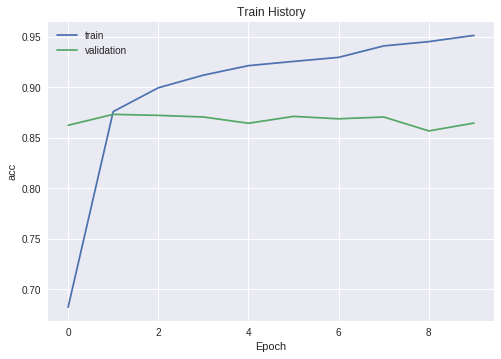

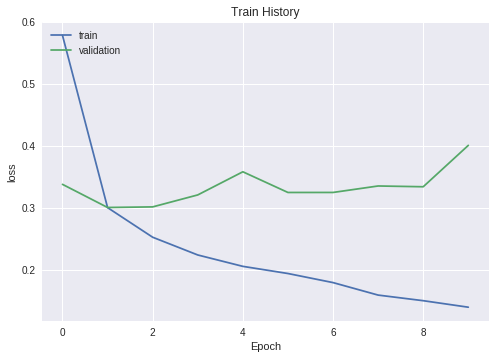

25000/25000 [==============================] - 34s 1ms/step
Accuracy of testing data = 85.9%


In [19]:
history = clf.fit(x=X_train, y=y_train,
                    validation_split=0.2,  
                    batch_size=200,
                    epochs=10, 
                    verbose=1)

show_train_history(history, 'acc', 'val_acc')
show_train_history(history, 'loss', 'val_loss')

scores = clf.evaluate(X_test, y_test)  
print("Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

Except for the CNN, RNN and LSTM layers we used in the tutorial, you may also want to play with other RNN variants such as gated recurrent units (GRU), bidirectional RNN/LSTM/GRU.
They are all available in Keras and all you need is computational resource.

Deep neural network has many variants and many hyperparameters for fine-tuning.
We are not going to explain all functions above.
If you are interested in the details of the models and want to fine-tune them, please definitely go to [Keras document](https://keras.io/) for more information.

We hope that this tutorial helps you understand the basic of deep neural network---feedforward neural network, CNN and RNN, and how to choose and use them in your clinical machine learning problems.

## Further reading

### Theory and mathematics
- [Deep learning book](http://www.deeplearningbook.org/)
- [Stanford CS224n: Natural Language Processing with Deep Learning](http://web.stanford.edu/class/cs224n/)
- [Stanford CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)

### Practical
You may want to read the documents of TensorFlow, PyTorch, Keras, Scikit-learn, ... etc. to know how to use them.

- [Tensorflow Programmer's Guide](https://www.tensorflow.org/programmers_guide/)
- [PyTorch Tutorials](https://pytorch.org/tutorials/)
- [Coursera Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)
- [Google Machine Learning Crash Course
](https://developers.google.com/machine-learning/crash-course/ml-intro)
- [Coursera Machine Learning with TensorFlow on Google Cloud Platform Specialization](https://www.coursera.org/specializations/machine-learning-tensorflow-gcp)